In [2]:
!kill -9 5499

In [1]:
!nvidia-smi

Mon Jan 19 13:20:28 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:02:00.0 Off |                  N/A |
|  0%   27C    P8             12W /  575W |      15MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
print("ok")

ok


In [3]:
import os

In [4]:
%pwd

'/home/bishwa/Unversity/Un-Conditional-Image-Generator/Research'

In [5]:
os.chdir('../')

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader,random_split, Subset

In [7]:
def add_noise(
        original_samples: torch.FloatTensor,
        timestep: torch.FloatTensor,
    ) -> torch.FloatTensor:
        
        noise = torch.randn(original_samples.shape, device=original_samples.device, dtype=original_samples.dtype)
        x_t = (1 - timestep) * original_samples + timestep * noise
        return x_t, noise


In [8]:
# Load an image
img = Image.open("data/Ben Affleck19_174.jpg").convert("RGB")

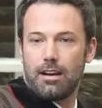

In [9]:
img

In [11]:
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor()
])
img_tensor = transform(img)

In [12]:
t = torch.rand(1)


In [13]:

noisy_image = add_noise(timestep=t, original_samples=img_tensor).clamp(0,1)

In [14]:
noisy_image = T.ToPILImage()(noisy_image)

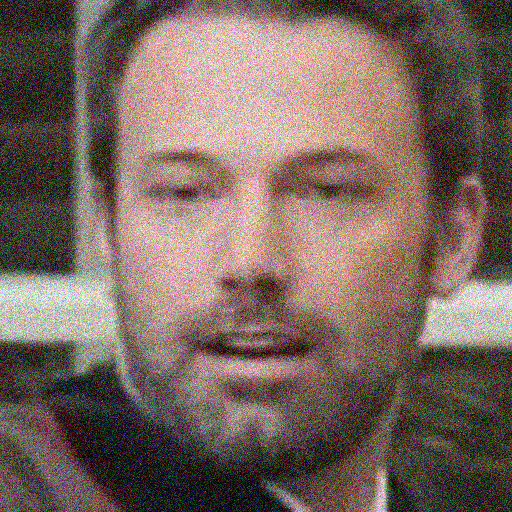

In [16]:
noisy_image

In [7]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img

In [8]:
transform = T.Compose([
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3) 
])

dataset = CustomDataset("data/", transform=transform)

In [23]:
#indices = np.random.choice(len(dataset), size=5000, replace=False)
#small_dataset = Subset(dataset, indices)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

In [10]:
len(train_dataset)

4000

In [22]:
len(val_dataset)

13534

In [24]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=6
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)


In [9]:
class NNDenoiser(nn.Module):
    def __init__(self, img_size=128, channels=3, hidden=4096):
        super().__init__()
        input_dim = img_size * img_size * channels

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, input_dim),
            nn.Tanh()  
        )
        self.img_size = img_size
        self.channels = channels

    def forward(self, x):
        B = x.shape[0]
        x = x.view(B, -1)
        x = self.net(x)
        x = x.view(B, self.channels, self.img_size, self.img_size)
        return x

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cpu'
model = NNDenoiser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [14]:
train_loss_history = []
val_loss_history = []

num_epochs = 50
save_every = 2

In [15]:
def add_noise(
        original_samples: torch.FloatTensor,
        timestep: torch.FloatTensor,
        noise: torch.FloatTensor
    ) -> torch.FloatTensor:
        x_t = (1 - timestep) * original_samples + timestep * noise
        return x_t

In [16]:
total_params = sum(p.numel() for p in model.parameters())
total_params

419489792

In [ ]:
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0
    for images in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images = images.to(device)
        B, C, H, W = images.shape
        K = 1000

        # repeat images
        imgs = images.unsqueeze(1).repeat(1, K, 1, 1, 1)   # (B, K, C, H, W)
        imgs = imgs.view(B*K, C, H, W)

        # sample noise
        noise = torch.randn_like(imgs)

        # sample t
        t = torch.rand(B*K, 1, 1, 1).to(device)

        xt = add_noise(imgs, t, noise)
        optimizer.zero_grad()
        pred_noise = model(xt)
        loss = loss_fn(pred_noise, noise - imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            images = images.to(device)
            B, C, H, W = images.shape
            K = 1000

            # repeat images
            imgs = images.unsqueeze(1).repeat(1, K, 1, 1, 1)   # (B, K, C, H, W)
            imgs = imgs.view(B*K, C, H, W)

            # sample noise
            noise = torch.randn_like(imgs)

            # sample t
            t = torch.rand(B*K, 1, 1, 1).to(device)

            xt = add_noise(imgs, t, noise)

            pred_noise = model(xt)
            loss = loss_fn(pred_noise, noise - imgs)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # save checkpoint 
    
    torch.save(model.state_dict(), f"artifacts/model_{epoch}.pt")

Epoch 1 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.25it/s]


Epoch 2: Train Loss = 1.0695, Val Loss = 1.0733


Epoch 2 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.26it/s]


Epoch 3: Train Loss = 1.0667, Val Loss = 1.0728


Epoch 3 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.25it/s]


Epoch 4: Train Loss = 1.0643, Val Loss = 1.0719


Epoch 4 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.25it/s]


Epoch 5: Train Loss = 1.0623, Val Loss = 1.0723


Epoch 5 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.26it/s]


Epoch 6: Train Loss = 1.0605, Val Loss = 1.0717


Epoch 6 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.28it/s]


Epoch 7: Train Loss = 1.0588, Val Loss = 1.0724


Epoch 7 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.29it/s]


Epoch 8: Train Loss = 1.0572, Val Loss = 1.0722


Epoch 8 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.29it/s]


Epoch 9: Train Loss = 1.0558, Val Loss = 1.0721


Epoch 9 [Val]: 100%|██████████| 439/439 [01:00<00:00,  7.27it/s]


Epoch 10: Train Loss = 1.0545, Val Loss = 1.0720


Epoch 10 [Train]:   1%|▏         | 23/1754 [00:07<08:57,  3.22it/s]

In [11]:
state_dict = torch.load("artifacts/model_29.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

NNDenoiser(
  (net): Sequential(
    (0): Linear(in_features=49152, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=49152, bias=True)
    (7): Tanh()
  )
)

In [12]:
def denormalize(x):
    # x in [-1, 1]
    return (x + 1) / 2

In [101]:
eta = 0.01

In [120]:
random_noise = torch.randn((3,128,128))

In [51]:
random_noise.shape

torch.Size([3, 128, 128])

In [132]:
i_0 = random_noise.unsqueeze(0).to(device)

In [16]:
def inference(i_0):
    pred_noise = model(i_0)
    pred_noise = i_0 - eta * pred_noise
    return pred_noise

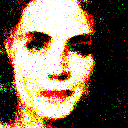

In [142]:
for i in range(5):
    i_0 = inference(i_0)
pred_x = i_0.squeeze(0)
image = denormalize(pred_x)
image = T.ToPILImage()(image.clamp(0,1))
image

In [139]:
i_0.shape

torch.Size([1, 3, 128, 128])

torch.Size([3, 128, 128])

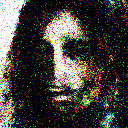

# Reserve 

In [68]:
pred_x = reverse_diffusion(pred_x, t,noise)

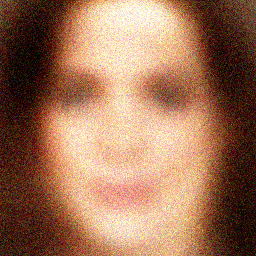

In [69]:
image = denormalize(pred_x)
image = T.ToPILImage()(image.clamp(0,1))
image

In Latent Phase

In [12]:
from diffusers import AutoencoderKL

/home/bishwa/Unversity/Un-Conditional-Image-Generator/un_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
vae_model = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")

/home/bishwa/Unversity/Un-Conditional-Image-Generator/un_env/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = NNDenoiser(img_size=64, channels=4, hidden=4096).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
vae_model = vae_model.to(device)

In [72]:
train_loss_history = []
val_loss_history = []

num_epochs = 50
save_every = 2

In [ ]:
for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0
    for images in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images = images.to(device)

        # random timesteps
        t = torch.rand(1).to(device)
        with torch.no_grad():
            images = vae_model.encode(images).latent_dist.sample()

        xt, noise = add_noise(images, t)

        optimizer.zero_grad()
        pred_noise = model(xt)
        loss = loss_fn(pred_noise, images - noise)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            images = images.to(device)
            t = torch.rand(1).to(device)
            with torch.no_grad():
                images = vae_model.encode(images).latent_dist.sample()
            xt, noise = add_noise(images, t)
            pred_noise = model(xt)
            loss = loss_fn(pred_noise, images - noise)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    # save checkpoint 
    if epoch % save_every == 0:
        torch.save(model.state_dict(), f"artifacts_latent/model_{epoch}.pt")

Epoch 1 [Val]: 100%|██████████| 1754/1754 [01:20<00:00, 21.75it/s]


Epoch 2: Train Loss = 30.3050, Val Loss = 29.4376


Epoch 2 [Val]: 100%|██████████| 1754/1754 [01:20<00:00, 21.79it/s]


Epoch 3: Train Loss = 29.4385, Val Loss = 28.5576


Epoch 3 [Train]:  19%|█▉        | 905/4676 [01:07<04:40, 13.42it/s]

In [15]:
state_dict = torch.load("artifacts_latent/model_16.pt", map_location="cpu")
model.load_state_dict(state_dict)
model.eval()

NNDenoiser(
  (net): Sequential(
    (0): Linear(in_features=16384, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=4096, bias=True)
    (7): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=4096, out_features=16384, bias=True)
    (10): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
  )
)

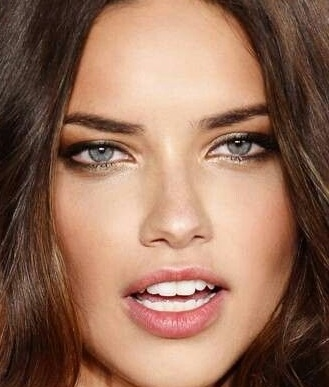

In [23]:
img = Image.open("data/Adriana Lima12_21.jpg").convert("RGB")
img

In [30]:
transform_img = transform(img).to(device)

In [33]:
transform_img = transform_img.unsqueeze(0)
transform_img.shape

torch.Size([1, 3, 512, 512])

In [34]:
with torch.no_grad():
    latent_images = vae_model.encode(transform_img).latent_dist.sample()

In [35]:
latent_images.shape

torch.Size([1, 4, 64, 64])

In [36]:
t = torch.rand(1).to(device)
xt, noise = add_noise(latent_images, t)

In [37]:
t

tensor([0.8106], device='cuda:0')

In [39]:
xt.shape

torch.Size([1, 4, 64, 64])

In [40]:
pred_x = model(xt)

In [41]:
pred_x.shape

torch.Size([1, 4, 64, 64])

In [49]:
recon_img = vae_model.decode(pred_x)

In [46]:
normalize_image = denormalize(recon_img.sample)


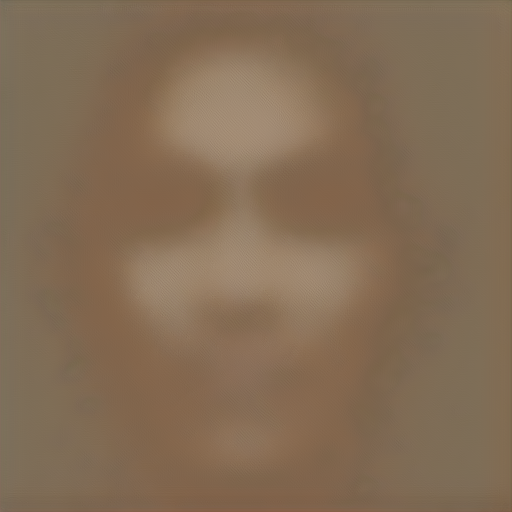

In [50]:
recon_img = (recon_img.sample / 2 + 0.5).clamp(0, 1)
recon_img = T.ToPILImage()(recon_img.squeeze())
recon_img